In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

### Data Recovery Rate for all sites

there are 388 sites in total

In [2]:
files = "C:/Users/zhongj/Desktop/Task3_Data" #go to files direction
os.chdir(files)

In [3]:
df= pd.read_csv("All_Sites_BTM_Solar_Data_Edit_15_Min_Interval.csv") 

In [4]:
Project_ID = list(df.columns)
Project_ID.remove('DateTime')
Project_ID.remove('Year')
Project_ID.remove('Month')
Project_ID.remove('Day')
Project_ID.remove('Hour')
Project_ID.remove('Min')

In [5]:
year = list(df['Year'].unique()) #get all unique years

### Data Recovery Rate for all sites


In [7]:
files = "C:/Users/zhongj/Desktop/Task3_Results/Data_Recovery_Rates/All_Sites" #go to files direction
os.chdir(files)

###### data recovery rate defined function

In [26]:
def drr_df(df, year, Project_ID):
    list_all= []
    list_y = []
    list_m = []
    for y in year:
        if y ==2021: #year 2021 only has 2 months
            month = [1,2]

        else:
            month = list(df['Month'].unique())

        for m in month: #each year and each month
            data_select = df[(df["Year"] == y)&(df["Month"] == m)] # choose the data
            data_select = data_select[Project_ID] #choose all sites
            total_n = len(data_select) # total number of rows (one number)

            list1 = list(data_select.isna().sum()) #total number of None for each sites (600 numbers)

            list2 = [(total_n - i)/total_n for i in list1] # Calculate the data recovery rate

            list_all.append(list2) 

            list_y.append(y)
            list_m.append(m)
            
    # make a dataframe for the data recovery rate
    df_na_ratio = pd.DataFrame(list_all)
    df_na_ratio.columns = Project_ID
    df_na_ratio['Year'] = list_y
    df_na_ratio['Month'] = list_m
    df_na_ratio['Date'] = pd.PeriodIndex(year = df_na_ratio['Year'], month = df_na_ratio['Month'],
                                freq = 'M')
    df_na_ratio.index = df_na_ratio['Date']
    del df_na_ratio['Year']
    del df_na_ratio['Month']
    
    return df_na_ratio

In [49]:
df_na_ratio = drr_df(df, year, Project_ID)

###### Data Recovery Rate -  Plots defined function

since there are too many sites, we don't want to plot then in one picture

In [14]:
def ddr_plots(n, p): # n: total sites p: how many plots you want to have
    count = math.ceil(n/p)
    for i in range(0, p):
        b = i*count # range begin
        e = (i+1)*count
        if e> n:
            e = n

        d = df_na_ratio.iloc[:, b:e]
        #setting:
        plt.figure(figsize=(25,15))
        plt.title('Data recovery rates in each Month for Sites %d-%d'%(b, e))

        #plot:
        sns.heatmap(d, cmap='Spectral', annot = True,linewidths=.1)
        plt.savefig('Data recovery rates in each Month for Sites %d-%d'%(b, e), bbox_inches="tight")
        plt.show()

In [ ]:
ddr_plots(388, 8)

In [50]:
df_na_ratio['Mean'] = df_na_ratio[Project_ID].mean(axis=1)

In [51]:
df_na_ratio['Date'] = df_na_ratio['Date'].map(lambda x: x.to_timestamp())
df_na_ratio['Date'] = pd.to_datetime(df_na_ratio['Date'])
df_na_ratio['Date'] = df_na_ratio['Date'].dt.date

In [52]:
from datetime import date
df_na_ratio2 = df_na_ratio.loc[(df_na_ratio['Date']!=date(2021,2,1))]

In [ ]:
df_na_ratio2

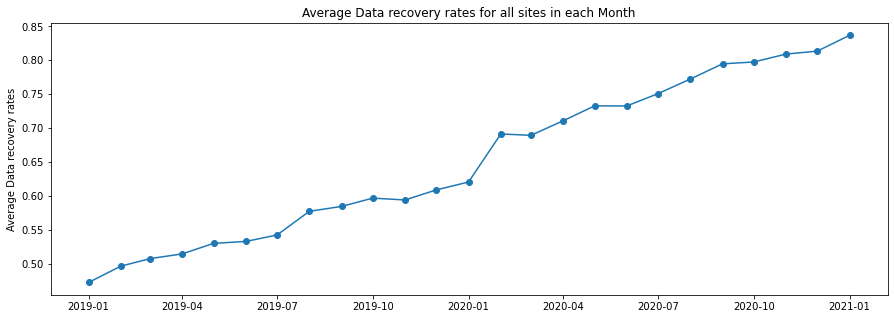

In [54]:
fig, ax = plt.subplots(1,1,figsize = (15,5))
plt.plot(df_na_ratio2['Date'],df_na_ratio2['Mean'], marker = 'o')
plt.ylabel('Average Data recovery rates')
plt.title('Average Data recovery rates for all sites in each Month')
plt.savefig('Average Data recovery rates for all sites in each Month', bbox_inches="tight")
plt.show()

In [14]:
del df_na_ratio['Date']

writer = pd.ExcelWriter(r'Data_Recovery_Rates_raw_files.xlsx', 
                                engine = 'xlsxwriter')
df_na_ratio.to_excel(writer)

writer.save()

## Sites Selection

In [19]:
sites1 = []
for p in Project_ID: 
    if len(df_na_ratio[df_na_ratio[p]>0.90])>=12: # choosing sites that have 12 months with data recovery rate >= 0.9
        sites1.append(p)
len(sites1)

227

In [20]:
df_na_ratio2 = df_na_ratio[sites1]

In [21]:
# choosing sites that have 12 concecutive months with data recovery rate >= 0.9 
final_sites = []
for p in sites1: #loop through all sites
    
    count = 0
    s = df_na_ratio2[p]
    
    for i, v in s.items(): # loop through all values in one site
        # for each value:
        if v >= 0.90: #if data recovery rate value >= 0.9:
            count +=1 # counts add 1
            
        else: #if value < 0.9 :
            if count >= 12: # if there are already 12 concecutive months:
                break #no need to see next values
            else: #if it doesn't have  12 concecutive months
                count = 0 #change count to 0
                
    if count >=12: # if here are 12 concecutive months:
        final_sites.append(p) # choose this site

final_sites.remove('710') #remove site 710 because there are more than not much data in 2020, and we want to only use 2020's data
        
len(final_sites)

190

In [22]:
df_na_ratio2 = df_na_ratio[final_sites]

In [23]:
#change columns' order:
c = ['DateTime', 'Year','Month', 'Day', 'Hour','Min'] 
for p in final_sites:
    c.append(p)
DF = df[c]


DF = DF[DF['Year']==2020] #only use 2020 data

In [24]:
# if the date recovery rate in a day is not 0, then I change the missing values that earlier than 8am, later that 5pm to 0.
# So it will make some of the data recovery rate 0.98 to 1s

In [25]:
DF['DateTime'] = pd.to_datetime(df['DateTime'])
DF['Date']= DF['DateTime'].dt.date
date = list(DF['Date'].unique())

In [26]:
list_all= []

for d in date:
    data_select = DF[DF['Date'] == d]
    data_select = data_select[final_sites]
    total_n = len(data_select)
    list1 = list(data_select.isna().sum())
    list2 = [(total_n - i)/total_n for i in list1]
    list_all.append(list2)
    
df_na_ratio0 = pd.DataFrame(list_all)
df_na_ratio0.columns = final_sites
df_na_ratio0['Date'] = date

In [27]:
for p in final_sites:
    for d in date:
        n = df_na_ratio0[df_na_ratio0['Date']== d][p].values[0]
        if n>0 and n<1 :
            DF[p].loc[(DF['Date']== d)&(DF[p].isnull())&(DF['Hour']<8)] = 0
            DF[p].loc[(DF['Date']== d)&(DF[p].isnull())&(DF['Hour']>17)] = 0

C:\Users\zhongj\Zhongj1\ZhongJ\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [28]:
del DF['Date']

###### Data recovery rates for chosen sites

In [29]:
df_na_ratio = drr_df(DF, [2020], final_sites)

In [30]:
files = "C:/Users/zhongj/Desktop/Data_Recovery_Rates/Chosen_Sites_2020" #go to files direction
os.chdir(files)

In [ ]:
ddr_plots(190, 8)

In [32]:
df_na_ratio['Mean'] = df_na_ratio[final_sites].mean(axis=1)
df_na_ratio['Date'] = df_na_ratio['Date'].map(lambda x: x.to_timestamp())
df_na_ratio['Date'] = pd.to_datetime(df_na_ratio['Date'])

In [33]:
del df_na_ratio['Date']

writer = pd.ExcelWriter(r'Data_recovery_rates_for_Chosen_Sites_2020.xlsx', 
                                engine = 'xlsxwriter')
df_na_ratio.to_excel(writer)

writer.save()

### Output chosen site data files

###### 15 mins interval:

In [5]:
files = "C:/Users/zhongj/Desktop/Task3_Data" #go to files direction
os.chdir(files)

In [34]:
DF.to_csv(r'Chosen_Sites_BTM_15_Min_Interval.csv', index = False)

In [6]:
DF = pd.read_csv("Chosen_Sites_BTM_15_Min_Interval.csv") #project id

In [11]:
files = "C:/Users/zhongj/Desktop/Task3_Data/Data_to_Use" #go to files direction
os.chdir(files)

In [7]:
columns_name = list(DF.columns)
columns_name.remove('Hour')
columns_name.remove('Min')

###### Hourly Interval

In [8]:
DF1 = DF.groupby(['Year', 'Month', 'Day','Hour']).sum()
DF1 = DF1.reset_index()
del DF1['Min']

In [42]:
DF1['DateTime'] = pd.PeriodIndex(year = DF1['Year'], month = DF1['Month'],
                            day = DF1['Day'], hour = DF1['Hour'], freq = 'H')
DF1['DateTime'] = DF1['DateTime'].map(lambda x: x.to_timestamp())

In [43]:
c = ['DateTime', 'Year','Month', 'Day', 'Hour']
for p in final_sites:
    c.append(p)
DF1 =  DF1[c]

In [45]:
DF1.to_csv(r'Chosen_Sites_BTM_Houly.csv', index = False)

###### Chosen Sites BTM Daily sum of data from 5am 9pm

In [15]:
DF2 = DF[(DF['Hour']>5)&(DF['Hour']<=21)].reset_index(drop = True)
DF2 = DF2.groupby(['Year', 'Month', 'Day']).sum()
DF2 = DF2.reset_index()
del DF2['Hour']
DF2['DateTime'] = pd.PeriodIndex(year = DF2['Year'], month = DF2['Month'],
                            day = DF2['Day'], freq = 'D')
# DF2['DateTime'] = DF2['DateTime'].map(lambda x: x.to_timestamp())

In [16]:
DF2 =  DF2[columns_name]

In [17]:
writer = pd.ExcelWriter(r'Chosen_Sites_BTM_Daily_5am_9pm.xlsx', 
                                engine = 'xlsxwriter')
DF2.to_excel(writer, index = False)

writer.save()

###### Chosen Sites BTM Daily(peak hour) sum of data from 10am 3pm

In [19]:
DF3 = DF[(DF['Hour']>10)&(DF['Hour']<=15)].reset_index(drop = True)
DF3 = DF3.groupby(['Year', 'Month', 'Day']).sum()
DF3 = DF3.reset_index()
del DF3['Hour']
DF3['DateTime'] = pd.PeriodIndex(year = DF3['Year'], month = DF3['Month'],
                            day = DF3['Day'], freq = 'D')
#DF3['DateTime'] = DF3['DateTime'].map(lambda x: x.to_timestamp())

In [20]:
DF3 =  DF3[columns_name]

In [21]:
writer = pd.ExcelWriter(r'Chosen_Sites_BTM_Daily_10am_3pm.xlsx', 
                                engine = 'xlsxwriter')
DF3.to_excel(writer, index = False)

writer.save()